# Overview

This assignment is designed to help you better understand TF-IDF and BM25 algorithms through implementing them from scratch, and applying them on the large-scale community Question-Answering (cQA) [LinkSO](https://dl.acm.org/doi/10.1145/3283812.3283815) dataset. Upon the successful completion of this assignment, you will develop a clear picture on how TF-IDF/BM25 algorithms work.

In this assignment, you will need to **run through** (i.e., running each code cell sequentially or `Runtime -> Run all`) the following pipeline:

- Step 0: load the dataset into the current environment;
- Step 1: import the libraries and helper functions;
- Step 2: preprocess the dataset to get the required inputs for the TF-IDF and BM25 algorithms;
- Step 3: implement the TF-IDF and BM25 algorithms.

We have already implemented Steps 1 through 3 of the pipeline. Step 4 is left for you to implement; it has three questions worthy of 30, 30, and 40 points, respectively.

**Suggestion**: Even though the code for Steps 1 through 3 has been provided, reading through all the code cells is **strongly recommended** before you start coding. Once you understand the provided code, the number of lines of code is unlikely to exceed 30.

**Runtime**: If you implement everything correctly, you will finish running this entire notebook within 90 minutes under `Stevens-Net`. If you are experiencing noticeable delay, check your network condition.

**Library requirement**: You are **NOT** allowed to use existing libraries that have already provided TF-IDF and BM25 implementations; other than these libraries, you are free to choose your preferred libraries.

**Note on Colab**: If a cell contains only a function, you should still run it (so the function compiles in Colab), even though it doesn't print any outputs.



## Step 0 - Load Dataset


Load and unzip the dataset from our remote GitHub repository that hosts the data and starter code.




In [36]:
! rm -rf cs589*
! git clone https://github.com/guanqun-yang/cs589assignment1.git
! unzip -o "cs589assignment1/dataset/*.zip" -d cs589assignment1/dataset


Cloning into 'cs589assignment1'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 23 (delta 0), reused 2 (delta 0), pack-reused 21
Receiving objects: 100% (23/23), 109.22 MiB | 18.23 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (8/8), done.
Archive:  cs589assignment1/dataset/java.zip
   creating: cs589assignment1/dataset/java/
  inflating: cs589assignment1/dataset/java/java_test_qid.txt  
  inflating: cs589assignment1/dataset/java/java_cosidf.txt  
  inflating: cs589assignment1/dataset/java/java_qid2all.txt  

Archive:  cs589assignment1/dataset/javascript.zip
   creating: cs589assignment1/dataset/javascript/
  inflating: cs589assignment1/dataset/javascript/javascript_test_qid.txt  
  inflating: cs589assignment1/dataset/javascript/javascript_qid2all.txt  
  inflating: cs589assignment1/dataset/javascript/javascript_cosidf.txt  

Archive:  cs589assignment1/dataset/pyth

## Step 1 - Import Libraries


Import the required libraries here. You could use additional libraries to help with your implementation.

In [37]:
import re
import os
import copy
import math
import random
import string
import pathlib
import itertools

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

from cs589assignment1.utils.common import save_pickle_file, load_pickle_file, load_text_file

base_path = pathlib.Path("cs589assignment1/dataset/")
tqdm.pandas()

In [38]:
def split_text(text):
    return text.split()


def load_qids(lang="java"):
    return [qid.strip(string.whitespace) for qid in load_text_file(base_path / pathlib.Path(f"{lang}/{lang}_test_qid.txt"))]


def load_qid_dataframe(lang="java"):
    qid_dataframe = pd.read_csv(base_path / pathlib.Path(f"{lang}/{lang}_cosidf.txt"),
                                sep="\t",
                                usecols=["qid1", "qid2", "label"],
                                dtype={"qid1": str, "qid2": str, "label": int})
    return qid_dataframe


def load_corpus(lang="java", verbose=False):
    lines = load_text_file(base_path / pathlib.Path(f"{lang}/{lang}_qid2all.txt"))

    record_list = list()
    for line in tqdm(lines, disable=not verbose):
        record_list.append(
            {name: text.strip(string.whitespace) for name, text in zip(["qid", "title", "question", "answer"], line.split("\t"))}
        )

    corpus_dataframe = pd.DataFrame(record_list)

    return corpus_dataframe

In [39]:
# take a look at the corpus
pd.set_option("display.max_columns", 10)

java_corpus_dataframe = load_corpus(lang="java", verbose=True)
print(java_corpus_dataframe.head())

100%|██████████| 159263/159263 [00:00<00:00, 269816.08it/s]


        qid                                     title  \
0  31424546   eclipse mars starts exit code using jdk   
1  31457289  efficient method updating observablelist   
2  16777228                          set title jtable   
3  27262998                  multiple websockets java   
4  46137348      find runtime error nzec java program   

                                            question  \
0  plan moving eclipse mars recently installed bi...   
1  setup mysql database data makeshift server bui...   
2  newbie java wanted set table header jtable tak...   
3  deprecated ok opening connection specific port...   
4  find runtime error nzec java program program r...   

                                              answer  
0  jdk bit download windows x version point vm mi...  
1  need would work keep list instance serverlist ...  
2  define variable containing column names must i...  
3  trying achieve multiple function listen server...  
4  try test code input like probably shall re

## Step 2 - Data Preprocessing



The following cell computes the term frequency (TF) for each word in each component in each StackOverflow question (indexed by the question ID `qid`).

In [40]:
def get_corpus_tf_dict(corpus_dataframe):
    """ Input: corpus_dataframe, e.g.,

         qid         title                 question          answer
 0  31424546   eclipse mars   eclipse moving eclipse    jdk download

        Output: corpus_tf_dict, the term frequency for each word in each component of each question, e.g.,
        {'31424546': {'title': {'eclipse': 1, 'mars': 1},
                      'question': {'moving': 1, 'eclipse': 2},
                      'answer': {'jdk': 1, 'download': 1}}}
    """
    cnt_dataframe = copy.deepcopy(corpus_dataframe)
    for c in ["title", "question", "answer"]:
        cnt_dataframe[c] = cnt_dataframe[c].progress_apply(lambda x: Counter(split_text(x)))

    corpus_tf_dict = cnt_dataframe.set_index("qid").to_dict("index")

    return corpus_tf_dict



The following cell computes the document length (dl) of each component in each StackOverflow question (indexed by the question ID `qid`).


In [41]:
def get_corpus_dl_dict(corpus_dataframe):
    """ Input: corpus_dataframe, e.g.,
         qid         title                 question          answer
0  31424546   eclipse mars   eclipse moving eclipse    jdk download

        Output: corpus_dl_dict, the document length for each component from each question, e.g.,
        {'31424546': {'title': 2,
                      'question': 3,
                      'answer': 2}}
    """
    length_dataframe = copy.deepcopy(corpus_dataframe)
    for c in ["title", "question", "answer"]:
        length_dataframe[c] = length_dataframe[c].progress_apply(lambda x: len(split_text(x)))

    corpus_dl_dict = length_dataframe.set_index("qid").to_dict("index")

    return corpus_dl_dict

The following cell computes the document frequency (DF) of each word in each StackOverflow question (indexed by the question ID `qid`). The definition of document frequency is how many document a word appears in, not to be confused with the word's frequency in the entire corpus. For example, the df of "eclipse" below is 2 instead of 3.

In [42]:
def get_corpus_df_dict(corpus_dataframe):
    """ Input: corpus_dataframe, e.g.,
         qid          title                 question          answer
 0  31424546   eclipse mars   eclipse moving eclipse    jdk download

        Output: corpus_df_dict, the document length for each component from each question, e.g.,
        {'eclipse': 2, "mars": 1, "moving": 1, "jdk": 1, "download": 1}
    """
    vectorizer = CountVectorizer(binary=True)

    X = vectorizer.fit_transform(corpus_dataframe.title.tolist() + \
                                 corpus_dataframe.question.tolist() + \
                                 corpus_dataframe.answer.tolist())
    corpus_df_dict = {token: doc_freq for token, doc_freq in \
                      zip(vectorizer.get_feature_names_out(), np.ravel(X.sum(axis=0)))}

    return corpus_df_dict

### Saving the Data Preprocessing Result

After computing the TF, DF and dl, cache each of them in a pickle file to be loaded later:

In [43]:
pkl_path = pathlib.Path("pkl/")
if not pkl_path.exists(): pkl_path.mkdir()

def save_preprocessing_results(lang):
    print(f"Processing {lang}...")

    lang_pkl_path = pkl_path / lang
    if not lang_pkl_path.exists(): os.mkdir(lang_pkl_path)

    # load corpus and convert corpus to various required data
    corpus_dataframe = load_corpus(lang=lang, verbose=True)

    # obtain the dictionary for the term frequency for each word in each component of each question
    corpus_tf_dict = get_corpus_tf_dict(corpus_dataframe)

    # saving the term frequency dictionary
    save_pickle_file(corpus_tf_dict, f"pkl/{lang}/corpus_tf_dict.pkl")

    # obtain the dictionary for the document length for each component in each question
    corpus_dl_dict = get_corpus_dl_dict(corpus_dataframe)

    # save the document length dictionary
    save_pickle_file(corpus_dl_dict, f"pkl/{lang}/corpus_dl_dict.pkl")

    # obtain the dictionary for the document frequency for each word in the corpus
    corpus_df_dict = get_corpus_df_dict(corpus_dataframe)

    # remove rare words
    corpus_df_dict = {k: v for k, v in corpus_df_dict.items() if v >= 20}

    # save the document frequency dictionary
    save_pickle_file(corpus_df_dict, f"pkl/{lang}/corpus_df_dict.pkl")

    return corpus_tf_dict, corpus_dl_dict, corpus_df_dict

Run the data processing pipeline for the 3 languages:

In [44]:
for lang in ["python", "java", "javascript"]:
     save_preprocessing_results(lang)

Processing python...


100%|██████████| 128500/128500 [00:00<00:00, 139521.79it/s]


Processing java...


100%|██████████| 159263/159263 [00:00<00:00, 235132.54it/s]


Processing javascript...


100%|██████████| 174015/174015 [00:00<00:00, 314691.48it/s]


Create the folder `result` to store results for Question 4 - 6 if it does not exist.

In [45]:
result_path = pathlib.Path("result")
if not result_path.exists(): result_path.mkdir()

## Step 3 - Implement the TF-IDF and BM25 Algorithms






### Question 1 (30 pts)
Compute the cosine similarity given dictionaries of word count, `query_dict` and `candidate_dict`.
When working with term frequencies, they are extracted from `corpus_tf_dict` using `corpus_tf_dict[qid][component]` syntax).

In [49]:
def compute_cosine_similarity(query_dict,
                              candidate_dict):
    """ Input: query_dict: a dict of word and its word count in query document, e.g.
               {"i": 1, "love": 1, "python": 1}
               candidate_dict: a dict of word and its word count in the candidate document, e.g.
               {"i": 1, "like": 1, "c++": 1}
        Output: score: cosine similary between query and candidate documents
                0.33333333333333337

    """

    score = 0
    #############################################START HERE#############################################
    # Question 1 (30 pts)
    den_q = 0
    den_d = 0
    words = set(query_dict.keys()).union(set(candidate_dict.keys()))
    for w in words:
        # Gather necessary information for cosine similarity
        den_q += query_dict.get(w, 0) ** 2
        den_d += candidate_dict.get(w, 0) ** 2
        score += query_dict.get(w, 0) * candidate_dict.get(w, 0)
    den = (den_q * den_d) ** (1/2)
    if den == 0:
        # If den is 0, assume similarity is 0 because either the query or the candidate are empty
        return 0
    score /= den
    ##############################################END HERE##############################################
    return score

Test your `compute_cosine_similarity` implementation on the Python corpus when retrieving candidate's title using query's title.

In [50]:
lang = "python"

corpus_tf_dict = load_pickle_file(f"pkl/{lang}/corpus_tf_dict.pkl")
qid_dataframe = load_qid_dataframe(f"{lang}")

result_dict = dict()
for qid1, qid2 in list(qid_dataframe[["qid1", "qid2"]].to_records(index=False)):
    result_dict[(qid1, qid2)] = compute_cosine_similarity(corpus_tf_dict[qid1]["title"],
                                                          corpus_tf_dict[qid2]["title"])


result_filename = pathlib.Path("result/Q4.txt")
if result_filename.exists(): os.remove(result_filename)

with open(result_filename, "a") as fp:
    fp.write("qid1\tqid2\tscore\n")
    for (qid1, qid2), score in result_dict.items():
        fp.write(f"{qid1}\t{qid2}\t{score}\n")

### Question 2 (30 pts)
Compute the TF-IDF score of each word in `document_tf_dict` and store it in the `document_word_tfidf_dict`.

For the total number of documents `N`, as our LinkSO dataset is scraped from the StackOverflow website, it is a small sample of the entire pool of posts, and the exact number of posts is constantly changing (see real-time statistics [here](https://api.stackexchange.com/docs/info#filter=default&site=stackoverflow&run=true) for all topics). For the sake of this assignment, we could set the total number of posts to a constant, for example, `N = 10 ** 6`, as an approximation.

Notice the example provided as docstring is used to help you understand the input and output data structures. You are not expected to reproduce the numbers exactly.

In [55]:
def compute_document_tfidf(document_tf_dict,
                           corpus_df_dict):
    """ Input: document_tf_dict: a dict of word and its term frequency in document
               {"i": 1, "love": 1, "python": 1}
               corpus_df_dict: a dict of word and its document frequencey in the entire corpus
               {"i": 2, "you": 1, "we": 3, "love": 1, "like": 1, "hate": 2, "python": 5, "c++": 3}
        Output: document_word_tfidf_dict: a dict of word and its TF-IDF score in the document
               {'i': 13.592366256649782, 'love': 14.103192380416024, 'python': 12.803907396283263}
    """
    document_word_tfidf_dict = dict()
    #############################################START HERE#############################################
    # Question 2 (30 pts)
    N = 10 ** 6
    for w in document_tf_dict:
        df = corpus_df_dict.get(w, 0)
        if df == 0:
            document_word_tfidf_dict[w] = 0
            continue
        document_word_tfidf_dict[w] = math.log(N / df) * document_tf_dict.get(w,0)
    ##############################################END HERE##############################################

    return document_word_tfidf_dict

Test your `compute_document_tfidf` implementation on the title component of the Java corpus.

In [56]:
lang = "java"

corpus_tf_dict = load_pickle_file(f"pkl/{lang}/corpus_tf_dict.pkl")
corpus_df_dict = load_pickle_file(f"pkl/{lang}/corpus_df_dict.pkl")
qid_dataframe = load_qid_dataframe(f"{lang}")

result_dict = dict()
for qid1 in qid_dataframe.qid1.tolist():
    result_dict[qid1] = compute_document_tfidf(corpus_tf_dict[qid1]["title"],
                                               corpus_df_dict)

result_filename = pathlib.Path("result/Q5.txt")
if result_filename.exists(): os.remove(result_filename)

with open(result_filename, "a") as fp:
    fp.write("qid1\ttoken\ttfidf\n")
    for qid1, d in result_dict.items():
        for token, score in d.items():
            fp.write(f"{qid1}\t{token}\t{score}\n")

### Question 3 (40 pts)

Compute the BM25 score between `query_tf_dict` and `candidate_tf_dict`. `N = 10 ** 6` following Question 2.

Notice the example provided as docstring is used to help you understand the input and output data structures. You are not expected to reproduce the numbers exactly.

In [57]:
def compute_document_bm25(query_tf_dict,
                          candidate_tf_dict,
                          corpus_df_dict,
                          candidate_length,
                          avgdl):
    """ Input: query_tf_dict: a dict of word and its term frequency in query document
               {"i": 1, "love": 1, "python": 1}
               candidate_tf_dict:a dict of word and its term frequency in candidate document
               {"i": 1, "like": 1, "c++": 1}
               corpus_df_dict: a dict of word and its document frequencey in the entire corpus
               {"i": 2, "you": 1, "we": 3, "love": 1, "like": 1, "hate": 2, "python": 5, "c++": 3}
               candidate_length: number of words in candidate document
               3
               avgdl: average document length in the entire corpus
               4
       Output: score: BM25 score between query and candidate
               15.816571644101565
    """


    # hyperparameters for BM25 algorithm
    k1, b = 3, 0.75

    score = 0
    #############################################START HERE#############################################
    # Question 3 (40 pts)
    N = 10 ** 6
    for w in query_tf_dict.keys():
        dfi = corpus_df_dict.get(w, 0)
        tfi = candidate_tf_dict.get(w, 0)
        if dfi == 0:
            continue
        num = tfi * (k1 + 1)
        den = k1 * (1 - b + b * (candidate_length/avgdl)) + tfi
        if den == 0:
            continue
        score += math.log(N/dfi) * num/den
    ##############################################END HERE##############################################

    return score


Test your `compute_document_bm25` implementation on the `title` component of the JavaScript corpus.

In [58]:
lang = "javascript"

corpus_tf_dict = load_pickle_file(f"pkl/{lang}/corpus_tf_dict.pkl")
corpus_df_dict = load_pickle_file(f"pkl/{lang}/corpus_df_dict.pkl")
corpus_dl_dict = load_pickle_file(f"pkl/{lang}/corpus_dl_dict.pkl")

qid_dataframe = load_qid_dataframe(f"{lang}")

corpus_dataframe = load_corpus(lang=lang, verbose=True)
avgdl = corpus_dataframe["title"].apply(lambda x: len(split_text(x))).sum() / len(corpus_dataframe)

result_dict = dict()
for qid1, qid2 in list(qid_dataframe[["qid1", "qid2"]].to_records(index=False)):
    result_dict[(qid1, qid2)] = compute_document_bm25(corpus_tf_dict[qid1]["title"],
                                                      corpus_tf_dict[qid2]["title"],
                                                      corpus_df_dict,
                                                      corpus_dl_dict[qid2]["title"],
                                                      avgdl)


result_filename = pathlib.Path("result/Q6.txt")
if result_filename.exists(): os.remove(result_filename)

with open(result_filename, "a") as fp:
    fp.write("qid1\tqid2\tscore\n")
    for (qid1, qid2), score in result_dict.items():
        fp.write(f"{qid1}\t{qid2}\t{score}\n")

100%|██████████| 174015/174015 [00:00<00:00, 344793.09it/s]


### Running Your Ranking Algorithms

The function `run_retrieval_algorithm` puts your implementations (`compute_cosine_similarity`, `compute_document_tfidf`, and `compute_document_bm25`) together and apply them to the entire dataset. Even though the code has been provided, it is recommended to read it to get a sense of how the retrieval pipeline works.

In [59]:
base_path = pathlib.Path("cs589assignment1/dataset/")

def run_retrieval_algorithm(lang, algo, component, qid1s=None):
    corpus_tf_dict = load_pickle_file(f"pkl/{lang}/corpus_tf_dict.pkl")
    corpus_dl_dict = load_pickle_file(f"pkl/{lang}/corpus_dl_dict.pkl")
    corpus_df_dict = load_pickle_file(f"pkl/{lang}/corpus_df_dict.pkl")

    corpus_dataframe = load_corpus(lang=lang, verbose=False)
    available_ids = corpus_dataframe.qid.unique()
    avgdl = corpus_dataframe[component].apply(lambda x: len(split_text(x))).sum() / len(corpus_dataframe)

    qid1s = qid1s if qid1s != None else load_qids(lang=lang)
    qid1_dataframe = load_qid_dataframe(lang=lang)

    result_folder = pathlib.Path("result/")
    if not result_folder.exists(): result_folder.mkdir()

    result_filename = pathlib.Path(f"result/{lang}_{algo}_{component}.txt")

    # remove existing result file
    if result_filename.exists():
        os.remove(result_filename)

    # write header
    with open(result_filename, "a") as fp:
        fp.write("qid1\tqid2\tscore\tlabel\n")

    for qid1 in tqdm(qid1s):
        if qid1 not in available_ids: continue

        cond1 = qid1_dataframe.qid1 == qid1
        cond2 = qid1_dataframe.label == 1

        qid2s = qid1_dataframe[cond1].qid2.tolist()
        qid2s_linked = qid1_dataframe[cond1 & cond2].qid2.tolist()

        qid1_tf_dict = corpus_tf_dict[qid1]["title"]
        query_result = dict()

        # only for BM25
        max_bm25 = -1
        for qid2 in qid2s:
            if qid2 not in available_ids: continue

            qid2_tf_dict = corpus_tf_dict[qid2][component]

            # tfidf
            if algo == "tfidf":
                score = compute_cosine_similarity(compute_document_tfidf(qid1_tf_dict, corpus_df_dict),
                                                  compute_document_tfidf(qid2_tf_dict, corpus_df_dict))

            # bm25
            if algo == "bm25":
                candidate_length = corpus_dl_dict[qid2][component]
                score = compute_document_bm25(qid1_tf_dict,
                                              qid2_tf_dict,
                                              corpus_df_dict,
                                              candidate_length,
                                              avgdl)

                max_bm25 = max(score, max_bm25)

            query_result[qid2] = score

        # adjust BM25 score
        if (algo == "bm25") and (max_bm25 != 0):
            query_result = {qid: score / max_bm25 for qid, score in query_result.items()}

        qid2s_sorted = sorted(query_result, key=query_result.get, reverse=True)

        with open(result_filename, "a") as fp:
            for qid2 in qid2s_sorted:
                label = 1 if qid2 in qid2s_linked else 0
                score = query_result[qid2]

                fp.write(f"{qid1}\t{qid2}\t{score}\t{label}\n")

Run the retrieval algorithms and save the ranking results for each language and each retrieval algorithms:

In [60]:
langs = ["python", "java", "javascript"]
algos = ["bm25", "tfidf"]
components = ["title", "question", "answer"]

for lang, algo, component in itertools.product(langs, algos, components):
    print(f"Running {algo} on {lang}'s {component}...")
    run_retrieval_algorithm(lang, algo, component)

Running bm25 on python's title...


100%|██████████| 1000/1000 [05:52<00:00,  2.84it/s]


Running bm25 on python's question...


100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


Running bm25 on python's answer...


100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


Running tfidf on python's title...


100%|██████████| 1000/1000 [05:33<00:00,  3.00it/s]


Running tfidf on python's question...


100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]


Running tfidf on python's answer...


100%|██████████| 1000/1000 [05:30<00:00,  3.03it/s]


Running bm25 on java's title...


100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]


Running bm25 on java's question...


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Running bm25 on java's answer...


100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


Running tfidf on java's title...


100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


Running tfidf on java's question...


100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]


Running tfidf on java's answer...


100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]


Running bm25 on javascript's title...


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


Running bm25 on javascript's question...


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


Running bm25 on javascript's answer...


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


Running tfidf on javascript's title...


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]


Running tfidf on javascript's question...


100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]


Running tfidf on javascript's answer...


100%|██████████| 1000/1000 [06:19<00:00,  2.64it/s]


### Preparing Submission
You need to download and submit the zipped `pkl/` and `result/` folders named after your CWID for submission.

- First make sure you have obtained all required files for submission. Your `pkl/` and `result/` directory should look **exactly** like the following. You could check this using `tree pkl/` and `tree result/`, which are both provided in the following code cell.

```bash
pkl/
├── java
│   ├── corpus_df_dict.pkl
│   ├── corpus_dl_dict.pkl
│   └── corpus_tf_dict.pkl
├── javascript
│   ├── corpus_df_dict.pkl
│   ├── corpus_dl_dict.pkl
│   └── corpus_tf_dict.pkl
└── python
    ├── corpus_df_dict.pkl
    ├── corpus_dl_dict.pkl
    └── corpus_tf_dict.pkl

result/
├── java_bm25_answer.txt
├── java_bm25_question.txt
├── java_bm25_title.txt
├── javascript_bm25_answer.txt
├── javascript_bm25_question.txt
├── javascript_bm25_title.txt
├── javascript_tfidf_answer.txt
├── javascript_tfidf_question.txt
├── javascript_tfidf_title.txt
├── java_tfidf_answer.txt
├── java_tfidf_question.txt
├── java_tfidf_title.txt
├── python_bm25_answer.txt
├── python_bm25_question.txt
├── python_bm25_title.txt
├── python_tfidf_answer.txt
├── python_tfidf_question.txt
├── python_tfidf_title.txt
├── Q4.txt
├── Q5.txt
└── Q6.txt
```

In [61]:
! tree pkl/
! tree result/

pkl/


├── java
│   ├── corpus_df_dict.pkl
│   ├── corpus_dl_dict.pkl
│   └── corpus_tf_dict.pkl
├── javascript
│   ├── corpus_df_dict.pkl
│   ├── corpus_dl_dict.pkl
│   └── corpus_tf_dict.pkl
└── python
    ├── corpus_df_dict.pkl
    ├── corpus_dl_dict.pkl
    └── corpus_tf_dict.pkl

4 directories, 9 files
result/
├── Q4.txt
├── Q5.txt
├── Q6.txt
├── java_bm25_answer.txt
├── java_bm25_question.txt
├── java_bm25_title.txt
├── java_tfidf_answer.txt
├── java_tfidf_question.txt
├── java_tfidf_title.txt
├── javascript_bm25_answer.txt
├── javascript_bm25_question.txt
├── javascript_bm25_title.txt
├── javascript_tfidf_answer.txt
├── javascript_tfidf_question.txt
├── javascript_tfidf_title.txt
├── python_bm25_answer.txt
├── python_bm25_question.txt
├── python_bm25_title.txt
├── python_tfidf_answer.txt
├── python_tfidf_question.txt
└── python_tfidf_title.txt

1 directory, 21 files


- Second, enter your Stevens CWID below and the run the following cells. After the running, open the file navigator on the left and download your `<CWID>.zip`.

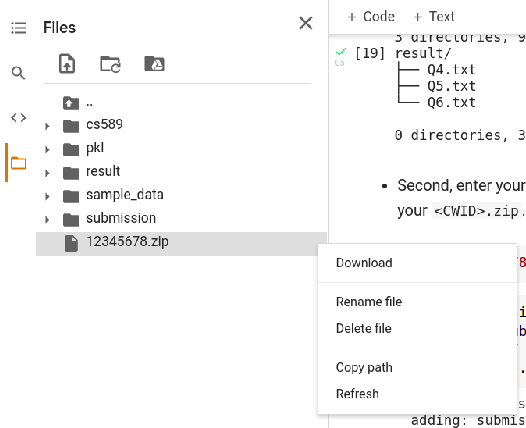

In [62]:
CWID = "10447681"

In [64]:
! mkdir submission/
! cp -r pkl/ submission/
! cp -r result/ submission/
! zip -r {CWID}.zip submission/

mkdir: cannot create directory ‘submission/’: File exists


  adding: submission/ (stored 0%)
  adding: submission/pkl/ (stored 0%)
  adding: submission/pkl/java/ (stored 0%)
  adding: submission/pkl/java/corpus_df_dict.pkl (deflated 77%)
  adding: submission/pkl/java/corpus_dl_dict.pkl (deflated 68%)
  adding: submission/pkl/java/corpus_tf_dict.pkl (deflated 71%)
  adding: submission/pkl/javascript/ (stored 0%)
  adding: submission/pkl/javascript/corpus_df_dict.pkl (deflated 77%)
  adding: submission/pkl/javascript/corpus_dl_dict.pkl (deflated 67%)
  adding: submission/pkl/javascript/corpus_tf_dict.pkl (deflated 72%)
  adding: submission/pkl/python/ (stored 0%)
  adding: submission/pkl/python/corpus_df_dict.pkl (deflated 77%)
  adding: submission/pkl/python/corpus_dl_dict.pkl (deflated 67%)
  adding: submission/pkl/python/corpus_tf_dict.pkl (deflated 71%)
  adding: submission/result/ (stored 0%)
  adding: submission/result/javascript_bm25_answer.txt (deflated 63%)
  adding: submission/result/javascript_bm25_question.txt (deflated 61%)
  adding